In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
import getpass
%matplotlib inline

In [2]:
username = getpass.getuser()

In [3]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
0,0,Baby,04192018_Baby,11.0,11.0,6.0,8.0,1.0,0.0,0.0,...,0.432,1.262,0.522,1.0,0.0,1.0,1.0,90-10,1.0,59.0
1,1,Baby,04192018_Baby,12.0,12.0,7.0,9.0,2.0,0.0,0.0,...,0.522,2.181,0.531,1.0,0.0,1.0,1.0,90-10,1.0,59.0
2,2,Baby,04192018_Baby,13.0,13.0,8.0,10.0,3.0,1.0,1.0,...,0.531,1.737,0.540,1.0,0.0,1.0,1.0,90-10,1.0,59.0
3,3,Baby,04192018_Baby,14.0,14.0,9.0,11.0,4.0,1.0,0.0,...,0.540,1.791,0.248,1.0,0.0,1.0,1.0,90-10,1.0,59.0
4,4,Baby,04192018_Baby,15.0,15.0,10.0,12.0,5.0,1.0,1.0,...,0.248,1.275,0.360,1.0,0.0,1.0,1.0,90-10,1.0,59.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [4]:
#include past 10 choice and reward values (this is most convenient given the current data structure)
choice_history = []
reward_history = []
for col in data.columns:
    if '_Port' in col:
        choice_history.append(data[col][:])
    elif '_Reward' in col:
        reward_history.append(data[col][:])
        
choice_history = np.transpose(np.asarray(choice_history))
reward_history = np.transpose(np.asarray(reward_history))
switch_history = np.abs(np.diff(choice_history)) # right now just missing whether or not switched on n-10 trial

#current trial decision and outcome 
choice = []
reward = []
switch = []

for col in data.columns:
    if 'Decision' in col:
        #print(col)
        choice.append(data[col][:])
    elif 'Reward' in col:
        #print(col)
        reward.append(data[col][:])
    elif 'Switch' in col:
        switch.append(data[col][:])

choice = np.transpose(np.asarray(choice))
reward = np.transpose(np.asarray(reward))
switch = np.transpose(np.asarray(switch))

### set up which datasets will be predictor and target

In [5]:
# set up as X and Y for logistic regression (X contains all predictors)
X = np.column_stack((choice_history, reward_history))
Y_choice = choice.ravel()
Y_switch = switch.ravel()

### split data into training and testing datasets
--right now 70% to train, 30% test

--X (train and test) mxn matrix with m trials and [n/2 choice, n/2 corresponding reward outcomes]
            
            X[:,0:9] = choice_history
            
            X[:,10:19] = reward_history

--Y (train and test) mx1 matrix with m trials and 1 choice outcome


In [6]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
idx = np.random.permutation(len(X))
cutoff = 0.7
idx_train = idx[0:int(len(X)*cutoff)]
idx_test = idx[int(len(X)*cutoff):]

X_train = X[idx_train]
X_test = X[idx_test]

Y_train_choice = Y_choice[idx_train]
Y_test_choice = Y_choice[idx_test]

Y_train_switch = Y_switch[idx_train]
Y_test_switch = Y_switch[idx_test]

### Logistic regression
Compare training on port choice (lr_port) vs training on switch (lr_switch)

In [7]:
lr_choice = LogisticRegression()
lr_choice.fit(X_train, Y_train_choice)

lr_predict_prob_choice = lr_choice.predict_proba(X_test)
lr_predict_choice = lr_choice.predict(X_test)
score_choice = lr_choice.score(X_test, Y_test_choice)
print('performance = {:.3f}'.format(score_choice))

performance = 0.928


In [8]:
switch_true = np.abs([Y_test_choice[i] - X_test[i,9] for i in range(len(Y_test_choice))]) # actually switches from test port (n) vs n-1 port (test[i,9])
switch_predict = np.abs([lr_predict_choice[i] - X_test[i,9] for i in range(len(lr_predict_choice))])

In [9]:
metrics_switch = sklearn.metrics.precision_recall_fscore_support(switch_true, switch_predict)
metrics_switch

/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.92827817,  0.        ]),
 array([ 1.,  0.]),
 array([ 0.96280525,  0.        ]),
 array([91117,  7040]))

In [10]:
metrics_choice = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr_predict_choice)
metrics_choice

(array([ 0.92844358,  0.92810835]),
 array([ 0.92986485,  0.9266543 ]),
 array([ 0.92915367,  0.92738076]),
 array([49647, 48510]))

### train on switches to predict switches

In [11]:
X = np.column_stack((switch_history, reward_history[:,0:8]))
X_train = X[idx_train]
X_test = X[idx_test]

# train and test LR
lr_switch = LogisticRegression()
lr_switch.fit(X_train, Y_train_switch)

lr_predict_prob_switch = lr_switch.predict_proba(X_test)
lr_predict_switch = lr_switch.predict(X_test)
score_switch = lr_switch.score(X_test, Y_test_switch)
print('performance = {:.3f}'.format(score_switch))

performance = 0.928


In [12]:
metrics_switch_2 = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr_predict_switch)
metrics_switch_2

(array([ 0.92832907,  0.42857143]),
 array([  9.99912201e-01,   8.52272727e-04]),
 array([ 0.96279193,  0.00170116]),
 array([91117,  7040]))

([<matplotlib.axis.XTick at 0x11baede10>,
 <a list of 3 Text xticklabel objects>)

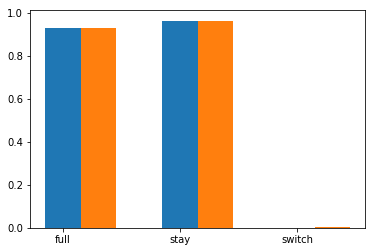

In [13]:
height_a = [score_choice, metrics_switch[2][0], metrics_switch[2][1]]
height_b = [score_switch, metrics_switch_2[2][0], metrics_switch_2[2][1]]
#height_c = [score_switch_2, metrics_switch_3[2][0], metrics_switch_3[2][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth)
plt.bar(r2, height_b, width=barWidth)
#plt.bar(r3, height_c, width=barWidth)
plt.xticks(range(len(height_a)), conditions)

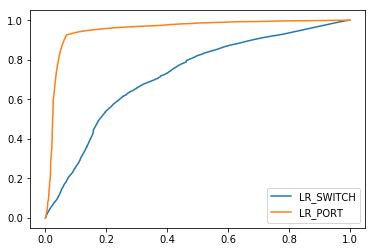

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(Y_test_switch, lr_predict_prob_switch[:,1])
plt.plot(fpr, tpr, label="LR_SWITCH")

fpr, tpr, _ = roc_curve(Y_test_choice, lr_predict_prob_choice[:,1])
plt.plot(fpr, tpr, label="LR_PORT")

plt.legend(loc='lower right')